# Sampling rate for Face Detection

All videos were downloaded at 30 FPS. Using this frame rate for detection gives us a 3:1 speedup from real time. Considering the large amount of footage required to process, further speedup is required. Another improvement is related to a smooth transition between frames. A phenomenon called jittering.

In [1]:
%matplotlib inline
import json
from datetime import timedelta
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

SAMPLE_LENGTH = 5.0
SAMPLE_NUM = 1000

np.random.seed(0)

experiments = [
    {'folder': r'D:/downloads/tracks@30FPS', 'label': '30FPS'},
]

In [2]:
data = {}

for e in experiments:
    d = dict(video_length=[], time_detecting=[], width=[], height=[])
    for track_file in Path(e['folder']).glob('**/*.tracks.json'):
        with track_file.open('r', encoding='utf8') as fp:
            track_file = json.load(fp)
        d['video_length'].append(track_file['video_duration'])
        d['time_detecting'].append(track_file['detection_duration'])
        d['width'].append(track_file['width'])
        d['height'].append(track_file['height'])
    data[e['label']] = d


print('Total video length:', timedelta(seconds=sum(data[experiments[0]['label']]['video_length'])))
print('Total time detecting:', timedelta(seconds=sum(data[experiments[0]['label']]['time_detecting'])))

Total video length: 1:10:54.566667
Total time detecting: 0:43:36.191178


We take a random sample of videos from the dataset. From these we take 5 second segments of detected bounding boxes. The 30 FPS samples will be our ground truth while subsamples of 15, 7, and 3FPS will be used as contrast. We will use the signal to noise ratio to check on the quality of the signals. We will use interpolation estrategies to complete the missing gaps in detection.

## Speedup by lowering frame rate

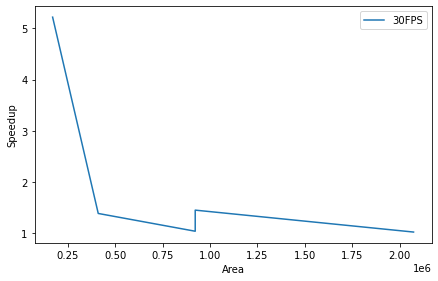

In [3]:
fig = plt.figure()
ax = plt.axes()

for label, d in data.items():
    area = np.float32(d['width']) * np.float32(d['height'])
    speedup = np.float32(d['video_length']) / np.float32(d['time_detecting'])
    
    # Order results by area
    idx = np.argsort(area)
    area = area[idx]
    speedup = speedup[idx]
    
    ax.plot(area, speedup, label=label)

fig.tight_layout()
plt.xlabel('Area')
plt.ylabel('Speedup')
plt.legend()
plt.show()

## Interpolation Methods

We try several interpolation methods and check the quality of the signal using the signal to noise ratio.
Will compute the time-normalized difference on consecutive detected centroids, widht and height.